In [45]:
import pandas as pd
import numpy as np
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt
from datetime import time
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

In [46]:
files = [
    'taq-td-ba12012008.csv',
    'taq-td-ba12022008.csv',
    'taq-td-ba12032008.csv',
    'taq-td-ba12042008.csv',
    'taq-td-ba12052008.csv'
]

data = {}
for file in files:
    date = file.split('/')[-1].split('.')[0].split('-')[-1]  
    data[date] = pd.read_csv(file)


for date, df in data.items():
    print(f"Data for {date}:")
    display(df.head())
    print('\n')

Data for ba12012008:


,Unnamed: 0,hour,min,second,price,volume
0,0,9,30,2,41.64,3441
1,1,9,30,2,41.64,3441
2,2,9,30,12,41.43,100
3,3,9,30,16,41.82,100
4,4,9,30,16,41.83,100




Data for ba12022008:


,Unnamed: 0,hour,min,second,price,volume
0,0,9,30,0,40.54,2136
1,1,9,30,0,40.54,2136
2,2,9,30,24,40.34,150
3,3,9,30,35,40.28,100
4,4,9,30,49,40.60,100




Data for ba12032008:


,Unnamed: 0,hour,min,second,price,volume
0,0,9,30,0,40.23,1055
1,1,9,30,0,40.23,1055
2,2,9,30,6,40.52,100
3,3,9,30,11,40.52,100
4,4,9,30,11,40.55,100




Data for ba12042008:


,Unnamed: 0,hour,min,second,price,volume
0,0,9,30,0,39.84,1232
1,1,9,30,0,39.84,1232
2,2,9,30,17,39.50,100
3,3,9,30,22,39.88,100
4,4,9,30,22,39.87,100




Data for ba12052008:


,Unnamed: 0,hour,min,second,price,volume
0,0,9,30,0,38.00,200
1,1,9,30,0,38.78,2130
2,2,9,30,0,38.78,2130
3,3,9,30,5,38.53,100
4,4,9,30,7,38.53,100


In [47]:
for date, df in data.items():
    print(f"Columns for {date}: {df.columns.tolist()}")

Columns for ba12012008: ['Unnamed: 0', 'hour', 'min', 'second', 'price', 'volume']
Columns for ba12022008: ['Unnamed: 0', 'hour', 'min', 'second', 'price', 'volume']
Columns for ba12032008: ['Unnamed: 0', 'hour', 'min', 'second', 'price', 'volume']
Columns for ba12042008: ['Unnamed: 0', 'hour', 'min', 'second', 'price', 'volume']
Columns for ba12052008: ['Unnamed: 0', 'hour', 'min', 'second', 'price', 'volume']


# 1-1

I will construct a time series of the number of trades in an intraday 5-minute time interval for each day and then analyze the series for any diurnal pattern by computing the sample autocorrelation function (ACF).

<Figure size 720x432 with 0 Axes>

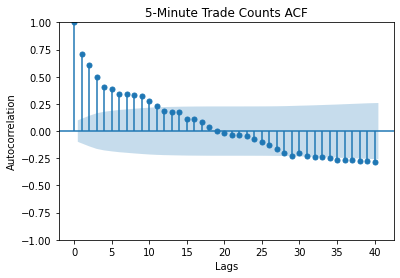

In [48]:
def aggregate_5min(df):
    df['DateTime'] = pd.to_datetime(df['hour'].astype(str) + ':' + df['min'].astype(str) + ':' + df['second'].astype(str), errors='coerce', format='%H:%M:%S')
    df = df.dropna(subset=['DateTime'])
    
    df.set_index('DateTime', inplace=True)
    
    df_resampled = df.resample('5T').count()['price']
    return df_resampled

corrected_aggregated_data_5min = {}
for date, df in data.items():
    corrected_aggregated_data_5min[date] = aggregate_5min(df)

all_trade_5min = pd.concat(corrected_aggregated_data_5min.values())

corrected_acf_values = acf(all_trade_5min, nlags=40) 

corrected_acf_values

plt.figure(figsize=(10, 6))
plot_acf(all_trade_5min, lags=40, title='5-Minute Trade Counts ACF')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()


# 1-2

In [49]:
def construct_5min_return_series(df):
    
    df['DateTime'] = pd.to_datetime(df['hour'].astype(str) + ':' + df['min'].astype(str) + ':' + df['second'].astype(str), errors='coerce', format='%H:%M:%S')
    df = df.dropna(subset=['DateTime'])
    df.set_index('DateTime', inplace=True)
    df_resampled = df['price'].resample('5T').last().dropna()
    returns = df_resampled.pct_change().dropna() * 100
    return returns

all_returns_5min = pd.concat([construct_5min_return_series(df) for df in data.values()])


In [50]:
from statsmodels.tsa.stattools import acf
from statsmodels.stats.diagnostic import acorr_ljungbox

acf_5min_returns = acf(all_returns_5min, nlags=10)

ljung_box_results_5min = acorr_ljungbox(all_returns_5min, lags=[10], return_df=True)

ljung_box_results_5min


,lb_stat,lb_pvalue
10,20.954798,0.021411


P-value is smaller than 0.05 -> Correlated

# 1-3

In [51]:
def construct_10min_return_series(df):
    df['DateTime'] = pd.to_datetime(df['hour'].astype(str) + ':' + df['min'].astype(str) + ':' + df['second'].astype(str), errors='coerce', format='%H:%M:%S')
    df = df.dropna(subset=['DateTime'])
    df.set_index('DateTime', inplace=True)
    df_resampled = df['price'].resample('10T').last().dropna()
    returns = df_resampled.pct_change().dropna() * 100
    return returns


In [52]:
all_returns_10min = pd.concat([construct_10min_return_series(df) for df in data.values()])


In [53]:
acf_10min_returns = acf(all_returns_10min, nlags=10)
print(acf_10min_returns)


[ 1.         -0.06142067  0.14022195 -0.02406741  0.02018888 -0.02844255
  0.0077417   0.02363285  0.03751051  0.09423408  0.08250153]


In [54]:
ljung_box_results_10min = acorr_ljungbox(all_returns_10min, lags=[10], return_df=True)
print(ljung_box_results_10min)


     lb_stat  lb_pvalue
10  8.599003   0.570534


# 1-4

In [55]:
def calculate_percentage_no_change(dataframes):
    no_change_counts = []
    total_counts = []
    for df in dataframes:
        price_changes = df['price'].diff()
        no_changes = price_changes == 0
        no_change_counts.append(no_changes.sum())
        total_counts.append(len(df))
    
    total_no_change = sum(no_change_counts)
    total_transactions = sum(total_counts)
    percentage_no_change = (total_no_change / total_transactions) * 100
    return percentage_no_change

percentage_no_change_all_days = calculate_percentage_no_change(data.values())
print(f"Percentage of consecutive transactions without price change: {percentage_no_change_all_days:.2f}%")


Percentage of consecutive transactions without price change: 57.07%


# 2-a

## (i)

Informed trader’s strategy is :

$$ x = \beta (v - \mu) $$

The total order flow is :

$$ q = x + u_1 + u_2 $$


$$E[v|q] = \mu + \frac {Cov(v,q)} {Var(q)} (q-E[q]) = \mu + \lambda q $$

Here, $\lambda = \frac {Cov(v,q)} {Var(q)}$, and since $Cov(v,q) = Cov(v,x) = \beta \sigma_v^2$ , (this is because noise trades $u_1$ and $u_2$ are 'uncorrelated with $v$') and $Var(q) = \beta^2 \sigma_v^2 + \sigma_{u1}^2 + \sigma_{u2}^2$

## (ii)

For given $x = \beta(v-\mu)$ and $q = x+u_1+u_2$ ,

$E[Profit] = E[(v-(\mu + \lambda q))x]$

Then,

$E[Profit] = E[(v-(\mu + \lambda (x+u_1+u_2)))\beta(v-\mu)]$

Diffentiate this $E[Profit]$ with respect to $\beta$ then search the point that makes diff. zero.

## (iii)



$$\lambda = \frac {\beta \sigma_v^2} {\beta^2 \sigma_v^2 + \sigma_{u1}^2 + \sigma_{u2}^2} $$

$$ E[Profit] = E[(v - (\mu + \lambda (\beta(v-\mu))))\beta (v-\mu)] $$

$$\frac d {d\beta} E[Profit] = 0$$

# 2-b

## (i)

Definition of $\lambda$ changes slightly since this will only reflect orders from informed traders and noisy traders in Group 2 :

$$\lambda = \frac {Cov(v, x+u_2)} {var(x+u_2)}$$



## (ii)

$$E[Profit] = E[(v-(\mu + \lambda (x+u_2))) \beta(v-\mu)]$$

$$\frac d {d\beta} E[Profit] = 0$$



## (iii)

$$\lambda = \frac {\beta \sigma_v^2} {\beta^2 \sigma_v^2 + \sigma_{u2}}$$

$$ E[Profit] = E[(v - (\mu + \lambda (\beta(v-\mu))))\beta (v-\mu)] $$

$$\frac d {d\beta} E[Profit] = 0$$

## 2-c

The main change in scenario (b) is that market makers know Group 1's noisy trading volumes in advance. This increases market transparency and allows market makers to provide more accurate pricing. 

This increases **market depth** and informative traders face **less price volatility**. 

Thus.. they have room to more actively reflect their information in the market.

Intuitively, the more information market makers have (i.e., when they know Group 1 deals), the less uncertain they face. 

**Less uncertainty means lower price impacts (λ), which means deeper markets.** Informative traders can use their information more actively in this deeper market to increase profits.